In [2]:
import os
import torch
import torch.nn as nn
from PIL import Image
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

2024-11-01 12:05:23.410599: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 12:05:23.472010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 12:05:23.914977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 12:05:24.818533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class DenoisingDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, is_train=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)
        self.is_train = is_train

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]

        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = (image - image.min()) / (image.max() - image.min())
        
        return image, label

In [4]:
image_size = 256

Transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_image_dir = 'dataset/label/Train'
train_label_dir = 'dataset/mask/Train'
val_image_dir = 'dataset/label/Val'
val_label_dir = 'dataset/mask/Val'

trainDataset = DenoisingDataset(train_image_dir, train_label_dir, Transform, is_train=True)
valDataset = DenoisingDataset(val_image_dir, val_label_dir, Transform, is_train=False)

batchSize = 16
trainLoader = DataLoader(trainDataset, batch_size=batchSize, num_workers=0, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=len(valDataset), num_workers=0)

In [5]:
unetmodel = smp.Unet(encoder_name='resnet34',in_channels=3, classes=1)

In [6]:
X, y = next(iter(trainLoader))

In [7]:
yHat = unetmodel(X)

print(yHat.shape)

summary(unetmodel, (3, 256, 256), device="cpu")

torch.Size([16, 1, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
         

In [8]:
writer = SummaryWriter(log_dir='seg_logs')

In [10]:
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unetmodel.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

epochs = 25
trainLosses, valLosses = [], []

for epoch in range(epochs):
    unetmodel.train()
    runningLoss = 0.0
    for batchIdx, (images, labels) in enumerate(trainLoader):

        yHat = unetmodel(images)
        l1_loss = lossfn(yHat, labels)
        total_loss = l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/Train', total_loss.item(), epoch*len(trainLoader)+batchIdx)
        runningLoss += total_loss.item()
    
    scheduler.step()

    avg_train_loss = runningLoss / len(trainLoader)
    trainLosses.append(avg_train_loss)
    writer.add_scalar('Training Loss', avg_train_loss, epoch)
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss: .4f}')

    if (epoch + 1) % 5 == 0:
        torch.save(unetmodel.state_dict(), f"unet_epoch_{epoch+1}.pth")
        print(f"Model weights saved at epoch {epoch+1}")

writer.close()
torch.save(unetmodel.state_dict(), "unet_model.pth")
print("Model Weights Saved Successfully")

Epoch 1/25, Training Loss:  0.4685
Epoch 2/25, Training Loss:  0.3466
Epoch 3/25, Training Loss:  0.2699
Epoch 4/25, Training Loss:  0.2245
Epoch 5/25, Training Loss:  0.1785
Model weights saved at epoch 5
Epoch 6/25, Training Loss:  0.1482
Epoch 7/25, Training Loss:  0.1261
Epoch 8/25, Training Loss:  0.1059
Epoch 9/25, Training Loss:  0.0938
Epoch 10/25, Training Loss:  0.0832
Model weights saved at epoch 10
Epoch 11/25, Training Loss:  0.0757
Epoch 12/25, Training Loss:  0.0760
Epoch 13/25, Training Loss:  0.0618
Epoch 14/25, Training Loss:  0.0561
Epoch 15/25, Training Loss:  0.0506
Model weights saved at epoch 15
Epoch 16/25, Training Loss:  0.0467
Epoch 17/25, Training Loss:  0.0433
Epoch 18/25, Training Loss:  0.0402
Epoch 19/25, Training Loss:  0.0391
Epoch 20/25, Training Loss:  0.0369
Model weights saved at epoch 20
Epoch 21/25, Training Loss:  0.0341
Epoch 22/25, Training Loss:  0.0346
Epoch 23/25, Training Loss:  0.0348
Epoch 24/25, Training Loss:  0.0326
Epoch 25/25, Train

In [11]:
Xval, yVal = next(iter(trainLoader))

yValPred = unetmodel(Xval[0:8, :, :, :])

tensor(0.8089)


tensor(0.8943)

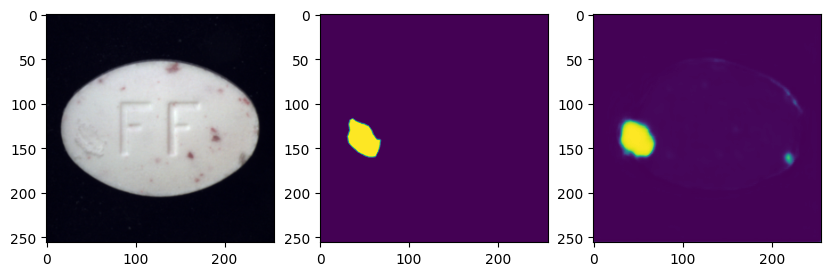

In [13]:
_, ax = plt.subplots(1, 3, figsize=(10, 8))

ax[0].imshow(Xval[3].detach().numpy().transpose(1, 2, 0))
ax[1].imshow(yVal[3].detach().numpy().transpose(1, 2, 0))
ax[2].imshow((torch.sigmoid(yValPred[3])).detach().numpy().transpose(1, 2, 0))

y_pred = torch.sigmoid(yValPred[3]) > 0.5
y_true = yVal[3] > 0.5

y_pred_binary = y_pred.float()
y_true_binary = y_true.float()

pixel_accuracy = (y_pred_binary == y_true_binary).float().mean()
pixel_accuracy

intersection = (y_pred_binary * y_true_binary).sum()
union = y_pred_binary.sum() + y_true_binary.sum() - intersection
iou = intersection / union

print(iou)

dice_coeff = (2 * intersection) / (y_pred_binary.sum() + y_true_binary.sum())

dice_coeff

# # torch.unique((torch.sigmoid(yValPred[0])>0.5).float())
# torch.sigmoid(yValPred[1])